# Image Clean-up

Images taken straight from the scanner need to be cleaned before further processing. This helps remove any unnecessary information that may influence our processing (and results!).

Here we will discuss two key clean-up operations:

1. Intensity normalisation (bias correction)
2. Brain extraction



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import nilearn
from nilearn import datasets
from nilearn import plotting
from nilearn.masking import apply_mask
import os
from bids import BIDSLayout

## Dataset

Here we will be using a subset of [AOMIC](https://nilab-uva.github.io/AOMIC.github.io/): the Amsterdam Open MRI Collection from [OpenNeuro](https://openneuro.org/datasets/ds002790/versions/2.0.0).

The anatomical data along with the processed derivatives are conveninetly organized in BIDS format! 

We have already downloaded data for 'sub-0001' or 'sub-0002' in the local_data/AOMIC directory. 


## Local paths

### The root data directory tree

In [10]:
!tree -d -C ../local_data/AOMIC

zsh:1: command not found: tree


### Derivatives (i.e. processed data)

In [59]:
!tree ../local_data/AOMIC/derivatives

zsh:1: command not found: tree


## Set Up Data Paths

In [9]:
local_data_dir = '../local_data/'

subject_id = 'sub-0001' # pick 'sub-0001' or 'sub-0002'

freesurfer_output_dir = local_data_dir + 'AOMIC/derivatives/freesurfer/{}/mri/'.format(subject_id)


Using sub-0001


## Image Clean-up Tasks

The image cleanup tasks have already been processed in the dataset we downloaded. These often use neuroimaging packages that specialise in these in these operations.

We will be using data that has been cleaned using a popular neuroimaging software package called [FreeSurfer](https://surfer.nmr.mgh.harvard.edu/fswiki/FreeSurferWiki).


## 1. Bias correction

The magnetic field in an MRI scanner can vary beyond what we originally expect. This can be due to an uneven magnetic field across the brain (also known as inhomogeneity), variations in how the scanner receives energy (the signal) and the interaction between the magnetic field and human body.

This creates a **bias field** which causes a smooth signal intensity variation within tissue. This means that the intensities at each voxel may not necessarily relate to the underlying tissue properties!

It is important to correct for this bias field before further processing to ensure it doesn't impact our results.

<img src=../fig/N4_bias.jpeg alt="Drawing" align="middle" width="500px"/>

## Using precomputed FreeSurfer output

### Compare the original and corrected images

### Files used:
- orig.mgz: input (raw) T1 image
- nu.mgz: [Output](https://surfer.nmr.mgh.harvard.edu/fswiki/nuintensitycor) of non-parametric Non-uniform intensity Normalization (N3)
- T1.mgz: [Output](https://surfer.nmr.mgh.harvard.edu/fswiki/normalization) of intensity normalization of the orig volume to correct for fluctuations in intensity that would otherwise make intensity-based segmentation much more difficult. Intensities for all voxels are scaled so that the mean intensity of the white matter is 110.


In [14]:
# first state the data from freesurfer outputs
T1_orig = freesurfer_output_dir + 'orig.mgz'
T1_corrected = freesurfer_output_dir + 'nu.mgz'

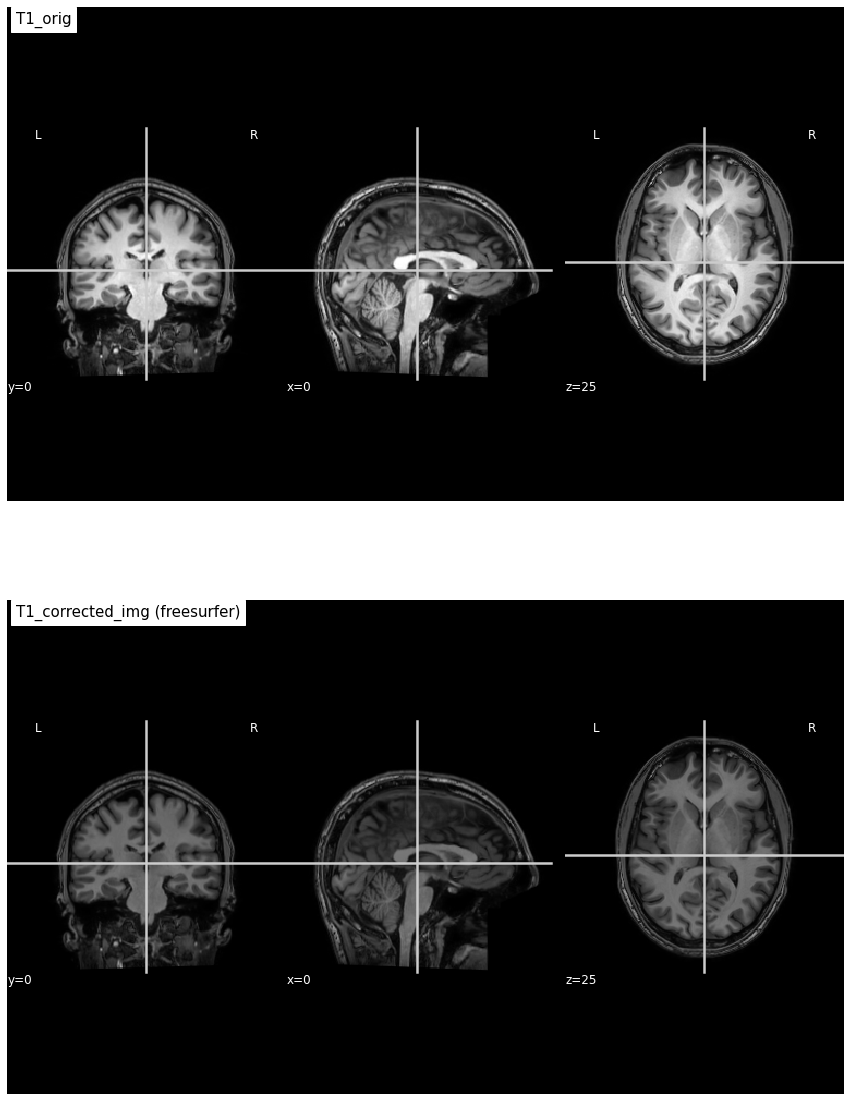

In [74]:
# now lets plot original and two following corrections of the bias field
cut_coords = (0,0,25)

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,20))

plotting.plot_anat(T1_orig, title="T1_orig", cut_coords = cut_coords, vmax=255, axes=ax1)
plotting.plot_anat(T1_corrected, title="T1_corrected_img (freesurfer)", cut_coords=cut_coords, vmax=255, axes=ax2)

## Plot intensity histogram

Remember, we want to infer biological properties from voxel intensities. Bias field correction should remove unwanted variation in voxel intensities that come from non-biological sources.

Lets see how the voxel intensities change before and after bias correction.

In [78]:
# use nibabel to load and get data (notice all in one line)
T1_data_orig = nib.load(T1_orig).get_fdata()
T1_data_corrected = nib.load(T1_corrected).get_fdata()

# check the shape
T1_data_orig.shape


(256, 256, 256)

Our image is 3 dimensional, how can we plot all voxel intensities on a 2 dimensional graph like a histogram?

Lets use a powerful reshaping commands in numpy called `ravel`. This *flattens* the 3 dimensional image into 1 dimensions (1 row of data) to allow for plotting.

In [79]:
# flatten our image
T1_data_orig = T1_data_orig.ravel()

The voxel intensities include many zeros (i.e. the background). We should remove these as it will skew our histogram!

Lets use indexing to only select voxels that do not equal zero with the `np.nonzero` command.

In [80]:
# keep voxels where their intensity is not zero
T1_data_orig = T1_data_orig[np.nonzero(T1_data_orig)]

Can you do the same for the bias corrected T1 data from FreeSurfer?

Solution

In [81]:
T1_data_corrected = T1_data_corrected.ravel()
T1_data_corrected = T1_data_corrected[np.nonzero(T1_data_corrected)]

Now lets plot a histogram of all the voxel intensities in our original and bias corrected images.

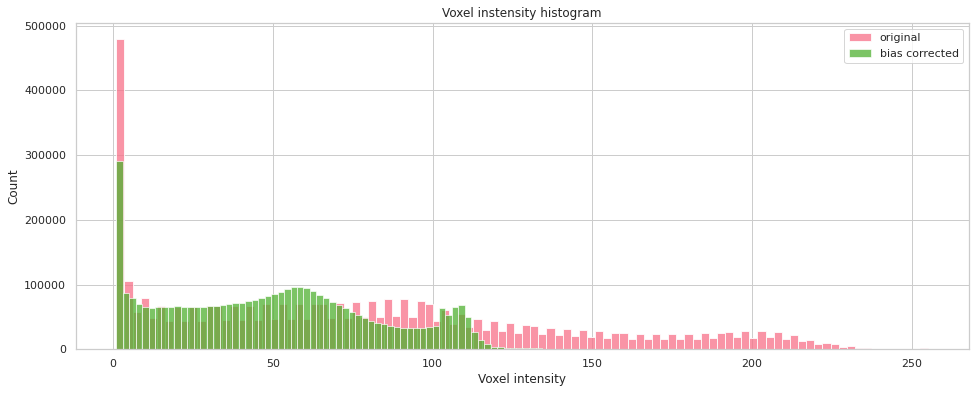

In [95]:
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

palette = sns.color_palette("husl", 3)

with sns.axes_style("whitegrid"):
    
    plt.figure(figsize=(16, 6))
    
    g = sns.histplot(T1_data_orig, bins=100, kde=False, color=palette[0], label='original')
    g = sns.histplot(T1_data_corrected, bins=100, kde=False, color=palette[1], label='bias corrected')

    plt.legend()
    plt.xlabel('Voxel intensity')
    plt.title('Voxel instensity histogram')

The voxel intensities clearly differ before and after bias correction.

Some peaks are visible in the bias corrected histogram. What could these represent?

## 2. Brain extraction

Image contrasts from nonbrain tissues such as fat, skull, or neck can cause issues with downstream analyses starting with brain tissue segmentation.

Brain extraction generates a mask that identifies brain voxels comprising grey matter (GM), white matter(WM), and Cerebrospinal fluid (CSF) of the cerebral cortex and subcortical structures, including the brain stem and cerebellum.

The scalp, dura matter, fat, skin, muscles, eyes, and bones are classified as nonbrain voxels.

This helps our processing focus on brain tissue of interest and reduces the chance of it accidentally including non-brain tissue as brain tissue. 

## Using precomputed FreeSurfer output

### Compare the original and corrected images

### Files used:
- T1.mgz: Normalized MR image (this is a further step after normalisation above)
- brainmask.mgz: brain extracted (i.e. skull stripped MR image)

In [83]:
T1_normalized = freesurfer_output_dir + 'T1.mgz'
T1_brain_extract = freesurfer_output_dir + 'brainmask.mgz'

T1_img_normalized = nib.load(T1_normalized)
T1_img_brain_extract = nib.load(T1_brain_extract)

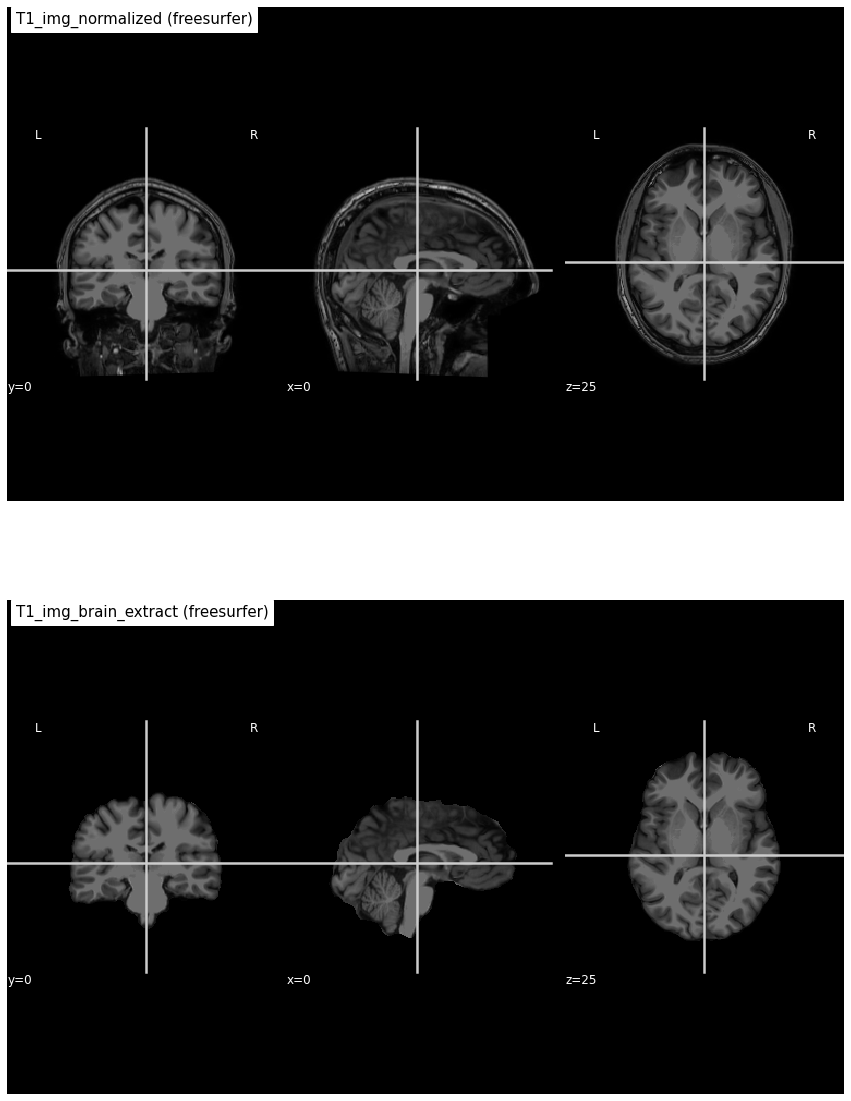

In [84]:
cut_coords = (0,0,25)

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,20))

plotting.plot_anat(T1_img_normalized, title="T1_img_normalized (freesurfer)", cut_coords=cut_coords, vmax=255, axes=ax1)
plotting.plot_anat(T1_img_brain_extract, title="T1_img_brain_extract (freesurfer)", cut_coords=cut_coords, vmax=255, axes=ax2)

Can you plot the voxel intensity histograms of the normalised and brain extracted images?

Solution

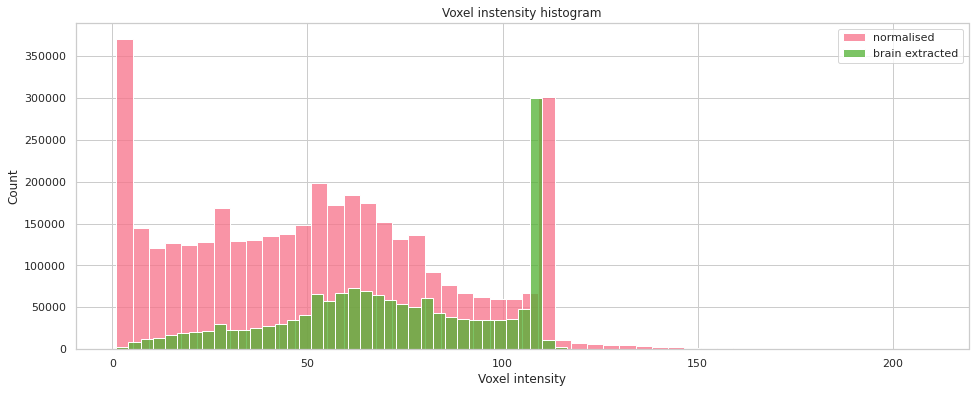

In [94]:
T1_img_normalized_data = T1_img_normalized.get_fdata().ravel()
T1_img_normalized_data = T1_img_normalized_data[np.nonzero(T1_img_normalized_data)]

T1_img_brain_extract_data = T1_img_brain_extract.get_fdata().ravel()
T1_img_brain_extract_data = T1_img_brain_extract_data[np.nonzero(T1_img_brain_extract_data)]


sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

palette = sns.color_palette("husl", 3)

with sns.axes_style("whitegrid"):
    
    plt.figure(figsize=(16, 6))
    
    g = sns.histplot(T1_img_normalized_data, bins=50, kde=False, color=palette[0], label='normalised')
    g = sns.histplot(T1_img_brain_extract_data, bins=50, kde=False, color=palette[1], label='brain extracted')

    plt.legend()
    plt.xlabel('Voxel intensity')
    plt.title('Voxel instensity histogram')

Based on the relaxation properties and signal intensities in a T1w image. Which tissue type do you think each peak represents in the brain extracted image?